# Plotting 

In this tutorial, we will explore `alphatools`' rich plotting functionalities.

In [ ]:
%load_ext autoreload
%autoreload 2

import logging

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string

from alphatools.pl import colors
from alphatools.pl.colors import show_rgba_color_list, BaseColors
from alphatools.pl.figure import create_figure, label_axes, save_figure
from alphatools.pl.plots import Plots, label_plot
from alphatools.pp.data import add_metadata


logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Basic colors, palettes and color maps for AlphaTools

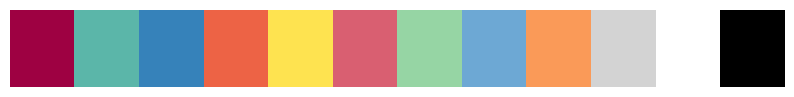

In [ ]:
# colors, derived from the basic palette
base_colors = [
    "red",
    "green",
    "blue",
    "orange",
    "yellow",
    "lightred",
    "lightgreen",
    "lightblue",
    "lightorange",
    "grey",
    "white",
    "black",
]
show_rgba_color_list([colors.BaseColors.get(base_color) for base_color in base_colors])

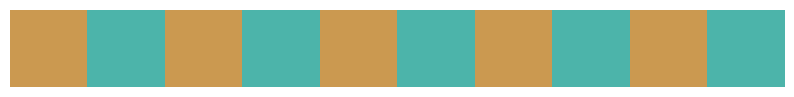

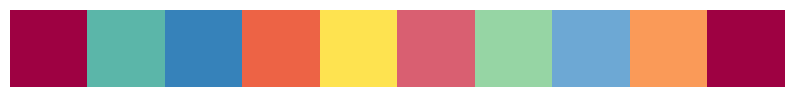

In [ ]:
# color palettes
palettes = ["binary", "qualitative"]
for palette in palettes:
    show_rgba_color_list(colors.BasePalettes.get(palette))

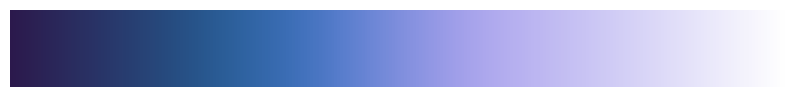

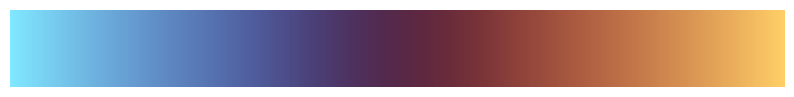

In [ ]:
# colormaps
maps = ["sequential", "diverging"]
for cmap in maps:
    show_rgba_color_list(list(colors.BaseColormaps.get(cmap)(np.arange(0, 1, 0.001))))

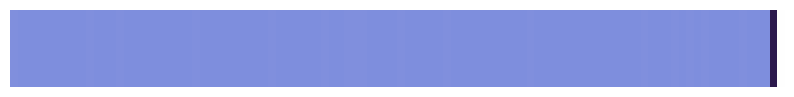

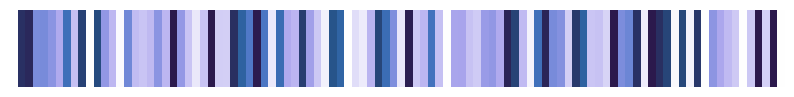

In [ ]:
test_data = [*list(np.random.rand(100)), -100, 100]

# map colormaps to numerical values without capping
mapped_colors = colors.MappedColormaps(
    cmap="sequential",
    percentile=None,
).fit_transform(test_data)
show_rgba_color_list(mapped_colors)

# map colormaps to numerical values with capping
mapped_colors = colors.MappedColormaps(cmap="sequential", percentile=(5, 95)).fit_transform(data=test_data)
show_rgba_color_list(mapped_colors)

## Plotting 

Demonstrate at_figure.py submodule style & label handling

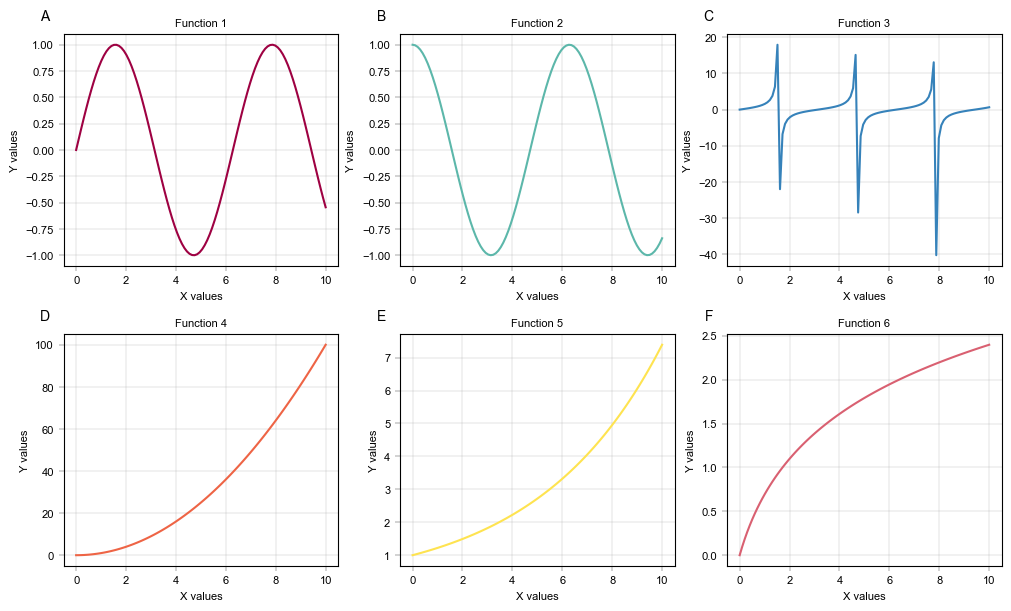

In [ ]:
# Create a 2x3 grid of subplots. Return an instance of AxisManager
fig, axm = create_figure(nrows=2, ncols=3, figsize=(10, 6))

# Example dataset
x = np.linspace(0, 10, 100)
y_funcs = [
    lambda x: np.sin(x),
    lambda x: np.cos(x),
    lambda x: np.tan(x),
    lambda x: x**2,
    lambda x: np.exp(x / 5),
    lambda x: np.log(x + 1),
]

# Get qualitative palette
palette = colors.BasePalettes.get("qualitative", len(y_funcs))

# Iterate through all axes using next() and plot different functions
try:
    for i, func in enumerate(y_funcs):
        ax = axm.next()
        ax.plot(x, func(x), color=palette[i])
        label_axes(
            ax,
            xlabel="X values",
            ylabel="Y values",
            title=f"Function {i + 1}",
            enumeration=list(string.ascii_uppercase)[i],
        )
except StopIteration:
    pass

plt.show()

# Save the figure
save_figure(
    fig=fig,
    filename="example_figure.png",
    output_dir="./example_outputs",
    dpi=300,
    transparent=False,
)

## Example data

In [ ]:
# Set up reproducible random number generation
rng = np.random.default_rng(seed=42)

example_df = pd.DataFrame(
    {
        "values": np.concatenate([rng.normal(i, size=200) + rng.normal(i) for i in range(3)]),
        "values2": np.concatenate([rng.normal(i, size=200) + rng.normal(i) for i in range(3)]),
        "levels": [i for i in range(3) for _ in range(200)],
        "levels2": np.arange(0, 600),
        "levels3": [i for i in [1, 5, 30] for _ in range(200)],
    }
)
example_df.index = example_df.index.astype(str)
# Introduce random NaN values into every column of example_df
for col in example_df.columns:
    example_df.loc[example_df.sample(frac=0.05, random_state=rng.integers(0, 2**32 - 1)).index, col] = np.nan
example_adata = ad.AnnData(
    X=example_df[["values", "values2"]].values,
    obs=example_df[["levels", "levels2", "levels3"]],
    var=example_df[["values", "values2"]].columns.to_frame(),
)

## Basic histogram with dataframe and AnnData

INFO:root:Column 'values' found in: data.var_names. Using that


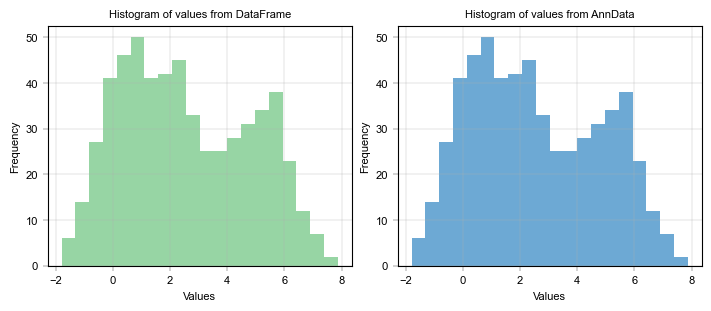

In [ ]:
# with one color
fig, axm = create_figure(1, 2, figsize=(7, 3))

# Show histogram based on DataFrame
ax = axm.next()
Plots.histogram(
    data=example_df,
    value_column="values",
    bins=20,
    color="lightgreen",
    ax=ax,
)
label_axes(ax, xlabel="Values", ylabel="Frequency", title="Histogram of values from DataFrame")

# Show histogram based on AnnData
ax = axm.next()
Plots.histogram(
    data=example_adata,
    value_column="values",
    bins=20,
    color="lightblue",
    ax=ax,
)
label_axes(ax, xlabel="Values", ylabel="Frequency", title="Histogram of values from AnnData")

INFO:root:Column 'values' found in: data.var_names. Using that
INFO:root:Column 'levels' found in: data.obs.columns. Using that


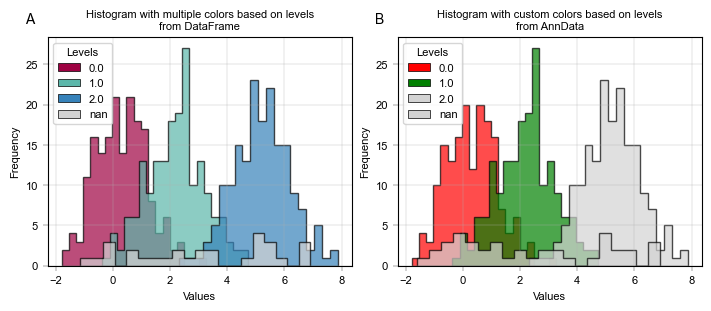

In [ ]:
# with multiple colors based on levels
fig, axm = create_figure(1, 2, figsize=(7, 3))

# Show histogram based on DataFrame
ax = axm.next()
palette = colors.BasePalettes.get("qualitative", example_df["levels"].nunique())
Plots.histogram(
    data=example_df,
    value_column="values",
    color_map_column="levels",
    palette=palette,
    bins=20,
    ax=ax,
    legend="auto",
    hist_kwargs={"alpha": 0.7, "histtype": "stepfilled", "edgecolor": "k"},
    legend_kwargs={"title": "Levels", "loc": "upper left"},
)
label_axes(
    ax,
    xlabel="Values",
    ylabel="Frequency",
    title="Histogram with multiple colors based on levels\nfrom DataFrame",
    enumeration="A",
)

# Show histogram based on AnnData with missing value handling
ax = axm.next()
palette = colors.BasePalettes.get("qualitative", example_adata.obs["levels"].nunique())
example_adata_copy = example_adata.copy()
example_adata_copy.obs.loc[example_adata_copy.obs.index[:10], "levels"] = np.nan

Plots.histogram(
    data=example_adata_copy,
    value_column="values",
    color_map_column="levels",
    palette=palette,
    color_dict={"0.0": "red", "1.0": "green"},  # custom colors for specific levels, omit level 2
    bins=20,
    ax=ax,
    legend="auto",
    hist_kwargs={"alpha": 0.7, "histtype": "stepfilled", "edgecolor": "k"},
    legend_kwargs={"title": "Levels", "loc": "upper left"},
)
label_axes(
    ax,
    xlabel="Values",
    ylabel="Frequency",
    title="Histogram with custom colors based on levels\nfrom AnnData",
    enumeration="B",
)

# Save the figure
save_figure(
    fig=fig,
    filename="example_histogram.png",
    output_dir="./example_outputs",
    dpi=300,
    transparent=False,
)

## Basic Scatterplot with DataFrame and AnnData

INFO:root:Column 'values' found in: data.var_names. Using that
INFO:root:Column 'values2' found in: data.var_names. Using that
INFO:root:Column 'values' found in: data.var_names. Using that
INFO:root:Column 'values2' found in: data.var_names. Using that


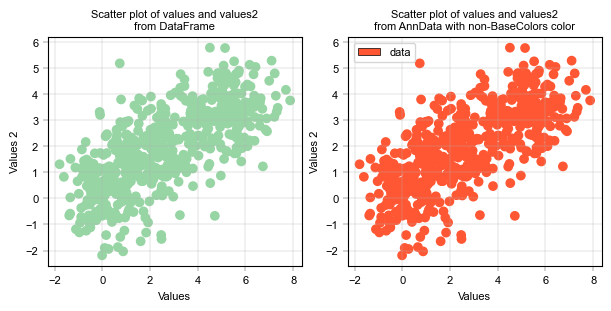

In [ ]:
fig, axm = create_figure(1, 2, figsize=(6, 3))

# Scatterplot based on DataFrame
ax = axm.next()
Plots.scatter(
    data=example_adata,
    x_column="values",
    y_column="values2",
    color=BaseColors.get("lightgreen"),  # Some color from AlphaTools' BaseColors
    ax=ax,
)

label_axes(ax, xlabel="Values", ylabel="Values 2", title="Scatter plot of values and values2\nfrom DataFrame")

# Scatterplot based on AnnData
ax = axm.next()
Plots.scatter(
    data=example_adata,
    x_column="values",
    y_column="values2",
    color="#FF5733",  # Some different color that is not in AlphaTools' BaseColors
    ax=ax,
    legend="auto",  # Automatically create a legend
)

label_axes(
    ax,
    xlabel="Values",
    ylabel="Values 2",
    title="Scatter plot of values and values2\nfrom AnnData with non-BaseColors color",
)

## Conveniently plot multiple levels in one scatterplot

INFO:root:Column 'levels' found in: data.obs.columns. Using that
INFO:root:Column 'levels' found in: data.obs.columns. Using that
INFO:root:Column 'values' found in: data.var_names. Using that
INFO:root:Column 'values2' found in: data.var_names. Using that
INFO:root:Column 'levels' found in: data.obs.columns. Using that
INFO:root:Column 'levels' found in: data.obs.columns. Using that
INFO:root:Column 'values' found in: data.var_names. Using that
INFO:root:Column 'values2' found in: data.var_names. Using that


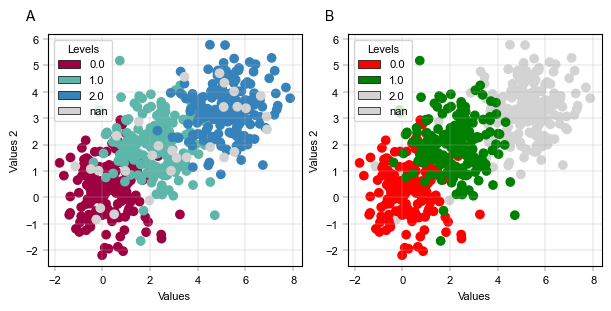

In [ ]:
# with multiple colors based on levels
fig, axm = create_figure(1, 2, figsize=(6, 3))

# Automatic coloring
ax = axm.next()
Plots.scatter(
    data=example_adata,
    x_column="values",
    y_column="values2",
    color_map_column="levels",
    ax=ax,
    legend="auto",
    palette=None,
    legend_kwargs={"title": "Levels", "loc": "upper left"},
)

label_axes(
    ax,
    xlabel="Values",
    ylabel="Values 2",
    enumeration="A",
)

# Custom coloring
ax = axm.next()
Plots.scatter(
    data=example_adata,
    x_column="values",
    y_column="values2",
    color_map_column="levels",
    ax=ax,
    legend="auto",
    color_dict={
        0.0: "red",
        1.0: "green",
    },  # Custom color dictionary, 2 is not included. We need to be explicit and exactly match the actual levels.
    legend_kwargs={"title": "Levels", "loc": "upper left"},
)

label_axes(
    ax,
    xlabel="Values",
    ylabel="Values 2",
    enumeration="B",
)

In [ ]:
from alphatools.pl import defaults

config = defaults.plot_settings.to_dict()

INFO:root:Column 'levels3' found in: data.obs.columns. Using that
INFO:root:Column 'levels3' found in: data.obs.columns. Using that
INFO:root:Column 'values' found in: data.var_names. Using that
INFO:root:Column 'values2' found in: data.var_names. Using that
INFO:root:Column 'levels2' found in: data.obs.columns. Using that
INFO:root:Column 'values' found in: data.var_names. Using that
INFO:root:Column 'values2' found in: data.var_names. Using that
INFO:root:Column 'levels3' found in: data.obs.columns. Using that
INFO:root:Column 'values' found in: data.var_names. Using that
INFO:root:Column 'values2' found in: data.var_names. Using that


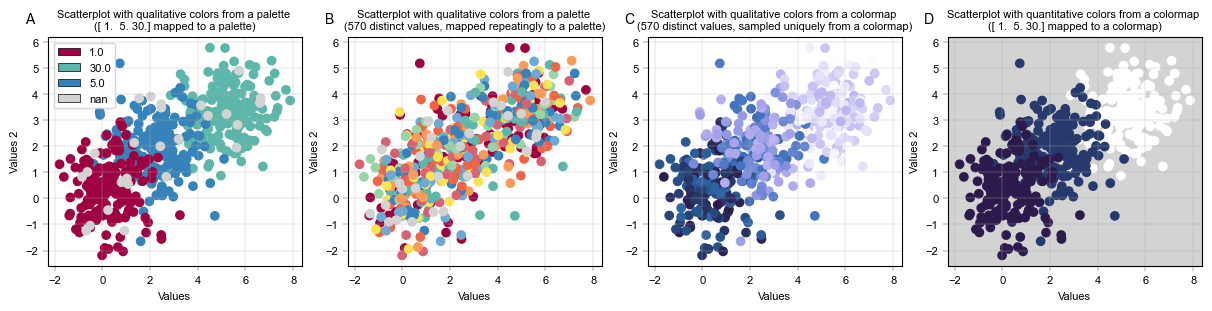

In [ ]:
# with a large number of levels and automatic shift to squential coloring
fig, axm = create_figure(1, 4, figsize=(12, 3))

# Coloring qualitative levels with a palette
ax = axm.next()
Plots.scatter(
    data=example_adata,
    x_column="values",
    y_column="values2",
    color_map_column="levels3",
    legend="auto",
    ax=ax,
    palette=None,
)

label_axes(
    ax,
    xlabel="Values",
    ylabel="Values 2",
    title=f"Scatterplot with qualitative colors from a palette \n({example_adata.obs['levels3'].dropna().unique()} mapped to a palette)",
    enumeration="A",
)

# By default, the standard color palette will just be repeated if there are many distinct values
ax = axm.next()
Plots.scatter(
    data=example_df,
    x_column="values",
    y_column="values2",
    color_map_column="levels2",
    ax=ax,
)

label_axes(
    ax,
    xlabel="Values",
    ylabel="Values 2",
    title=f"Scatterplot with qualitative colors from a palette \n({example_adata.obs['levels2'].nunique()} distinct values, mapped repeatingly to a palette)",
    enumeration="B",
)

# If we want to avoid color repetition, we can use a sequential colormap instead. If the values are not numeric, this will
# simply assign a distinct color to each level with no particular order.
ax = axm.next()
Plots.scatter(
    data=example_adata,
    x_column="values",
    y_column="values2",
    color_map_column="levels2",
    ax=ax,
    palette=colors.BaseColormaps.get("sequential"),
)

label_axes(
    ax,
    xlabel="Values",
    ylabel="Values 2",
    title=f"Scatterplot with qualitative colors from a colormap \n({example_adata.obs['levels2'].nunique()} distinct values, sampled uniquely from a colormap)",
    enumeration="C",
)

# However, when the values are numerical and we care about their quantitative relationship, we can map them to a colormap.
ax = axm.next()
ax.set_facecolor(colors.BaseColors.get("lightgrey"))
Plots.scatter(
    data=example_adata,
    x_column="values",
    y_column="values2",
    color_map_column="levels3",
    legend="auto",
    ax=ax,
    palette=colors.BaseColormaps.get("sequential"),  # force quantitative mapping of the numerical column to a colormap
)

label_axes(
    ax,
    xlabel="Values",
    ylabel="Values 2",
    title=f"Scatterplot with quantitative colors from a colormap \n({example_adata.obs['levels3'].dropna().unique()} mapped to a colormap)",
    enumeration="D",
)

plt.show()

## Labelling data with anchors

INFO:root:Column 'x' found in: data.var_names. Using that
INFO:root:Column 'y' found in: data.var_names. Using that
INFO:root:Column 'x' found in: data.var_names. Using that
INFO:root:Column 'y' found in: data.var_names. Using that


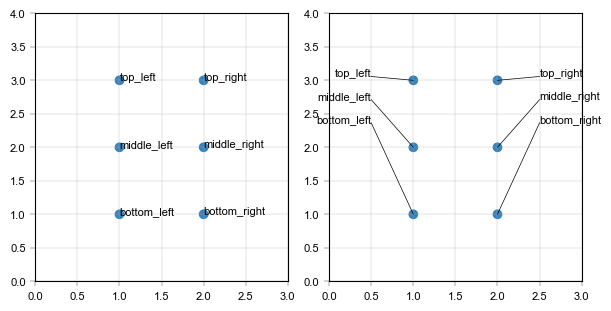

In [ ]:
testdata = ad.AnnData(
    pd.DataFrame(
        {
            "x": [2, 1, 2, 1, 2, 1],
            "y": [2, 2, 3, 3, 1, 1],
        },
        index=["A", "B", "C", "D", "E", "F"],
    )
)

testlabels = pd.DataFrame(
    {
        "label": ["middle_right", "middle_left", "top_right", "top_left", "bottom_right", "bottom_left"],
    },
    index=["A", "B", "C", "D", "E", "F"],
)

testdata = add_metadata(testdata, testlabels, axis=0)

fig, axm = create_figure(1, 2, figsize=(6, 3))

# Labels are extracted from the anndata object
# TODO: change this so that label_plot takes the anndata object directly
label_df = testdata.to_df().join(testdata.obs)

### Label without and with anchors
for x_anchors in [None, (0.5, 2.5)]:
    ax = axm.next()
    Plots.scatter(
        data=testdata,
        x_column="x",
        y_column="y",
        ax=ax,
    )

    label_lines = label_plot(
        ax=ax,
        x_values=label_df["x"],
        y_values=label_df["y"],
        labels=label_df["label"],
        x_anchors=x_anchors,
        y_display_start=3.20,
        y_padding_factor=10,
    )

    ax.set_xlim(0, 3)
    ax.set_ylim(0, 4)

## Differential expression data

In [ ]:
# Set up reproducible random number generation
rng = np.random.default_rng(seed=42)

# example data, should be replaced by actual differential expression results from example file
testx = rng.normal(0, 1, 300)
testy = -np.cos(testx) + rng.normal(0, 0.2, 300)
testp = 10 ** -(testy - min(testy))
vp_data = pd.DataFrame(
    {
        "id": [f"P{10000 + i}" for i in range(300)],
        "gene": [f"gene_{i}" for i in range(300)],
        "log2fc": testx,
        "pval": testp,
        "neg_log10pval": -np.log10(testp),
    }
)
vp_data.index = vp_data["id"].astype(str)
example_adata_diff = ad.AnnData(
    X=vp_data[["log2fc", "pval", "neg_log10pval"]].values,
    obs=vp_data[["id", "gene"]],
    var=vp_data[["log2fc", "pval", "neg_log10pval"]].columns.to_frame(),
)

INFO:root:Column 'log2fc' found in: data.var_names. Using that
INFO:root:Column 'neg_log10pval' found in: data.var_names. Using that


(-7.0, 7.0)

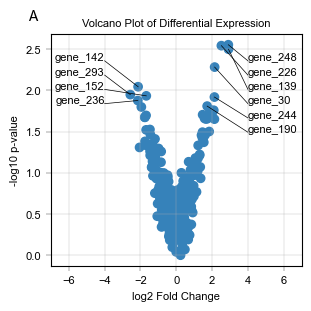

In [ ]:
# Visualize volcanoplot
fig, axm = create_figure(1, 1, figsize=(3, 3))
ax = axm.next()

Plots.scatter(
    ax=ax,
    data=example_adata_diff,
    x_column="log2fc",
    y_column="neg_log10pval",
)

# Extract points to label
label_data = (
    example_adata_diff.to_df().join(example_adata_diff.obs).sort_values("neg_log10pval", ascending=False).head(10)
)

label_plot(
    ax=ax,
    x_values=label_data["log2fc"],
    y_values=label_data["neg_log10pval"],
    labels=label_data["gene"],
    y_display_start=2.5,
    y_padding_factor=5,
    x_anchors=[-4, 4],
)

label_axes(
    ax,
    xlabel="log2 Fold Change",
    ylabel="-log10 p-value",
    title="Volcano Plot of Differential Expression",
    enumeration="A",
)

ax.set_xlim((-7, 7))